In [72]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt

#Declare constants
c = 299792458
center_wave=1500e-9

#Simulation parameters
span = 50e-9
min_step = 2.2930e-11
propagationLoss = 0

n_eff0 = 3.2
n_eff1 = 3.2
n_eff2 = 3.7

#number of gratings 
N = 200
#length of each grating segment
l = 221e-9
#total length of grating is N * l

In [73]:
#Transfer Matrix Method
def calculate_reflection_transmission(wavelength, n_eff0, n_eff1, n_eff2, N, l, propagationLoss):
    r_12 = (n_eff1 - n_eff2)/(n_eff1+n_eff2)
    r_21 = (n_eff2 - n_eff1)/(n_eff1+n_eff2)
    t_12 = (2 * n_eff1)/(n_eff1+n_eff2)
    t_21 = (2 * n_eff2)/(n_eff1+n_eff2)

    T20 = np.array([[(n_eff2 + n_eff0)/(2 * n_eff2), (n_eff2 - n_eff0)/(2 * n_eff2)],
                    [(n_eff2 - n_eff0)/(2 * n_eff2), (n_eff2 + n_eff0)/(2 * n_eff2)]])
    T01 = np.array([[(n_eff0 + n_eff1)/(2 * n_eff0), (n_eff0 - n_eff1)/(2 * n_eff0)],
                    [(n_eff0 - n_eff1)/(2 * n_eff0), (n_eff0 + n_eff1)/(2 * n_eff0)]])

    T12 = np.array([[1/t_12, r_12/t_12],
                    [r_12/t_12, 1/t_12]])
    T21 = np.array([[1/t_21, r_21/t_21],
                    [r_21/t_21, 1/t_21]])

    beta1 = (2 * np.pi * n_eff1)/wavelength - (propagationLoss/2)*1j
    beta2 = (2 * np.pi * n_eff2)/wavelength - (propagationLoss/2)*1j

    #populate propagation matrices
    P1 = np.array([[np.exp(beta1 * l * 1j), 0],
                   [0, np.exp(beta1 * l * -1j)]
                   ])
    P2 = np.array([[np.exp(beta2 * l * 1j), 0],
                   [0, np.exp(beta2 * l * -1j)]
                   ])

    #Multiply Matrices Together
    M = T01
    for i in range(N):
        if i == N - 1:
            M = M @ P1 @ T12 @ P2 @ T20
        else:
            M = M @ P1 @ T12 @ P2 @ T21
            
    #Calculate reflectance and transmittance 
    R = abs((M[1,0]/M[0,0]))**2
    T = abs(1/M[0,0])**2
    return R, T

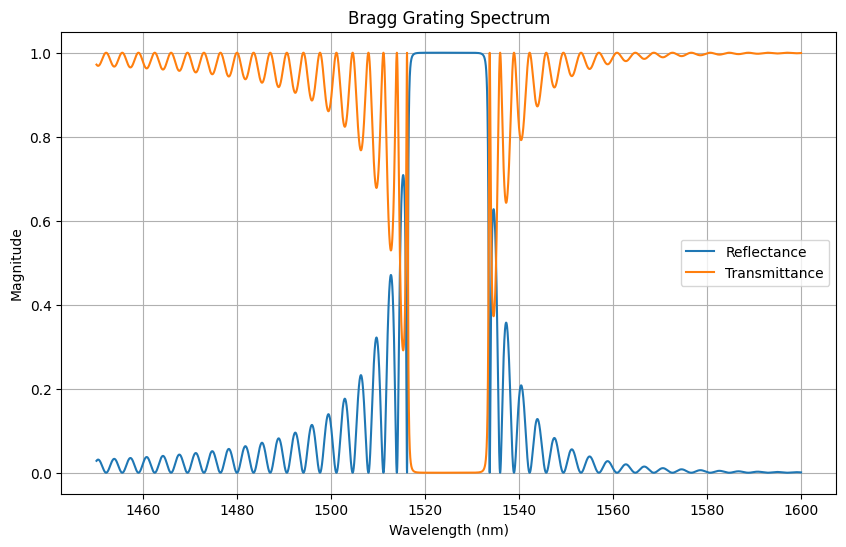

In [74]:
# Define the wavelength spectrum
wavelengths = np.linspace(1450e-9,1600e-9,10000)

# Calculate Reflectance and Transmittance over the spectrum
R_list = []
T_list = []

for wl in wavelengths:
    R, T = calculate_reflection_transmission(wl, n_eff0, n_eff1, n_eff2, N, l, propagationLoss)
    R_list.append(R)
    T_list.append(T)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(wavelengths * 1e9, R_list, label='Reflectance')
plt.plot(wavelengths * 1e9, T_list, label='Transmittance')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')
plt.title('Bragg Grating Spectrum')
plt.legend()
plt.grid(True)
plt.show()